In [1]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
data_path = '/kaggle/input/chestxraydataset/chest_xray/train'

In [4]:
train_data = []
val_data = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    file = os.listdir(folder_path)
    num_train = int(0.8 * len(file))
    files_train = random.sample(file, num_train)
    files_val = list(set(file) - set(files_train))
    
    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        train_data.append((img, folder))
        
    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        val_data.append((img, folder))

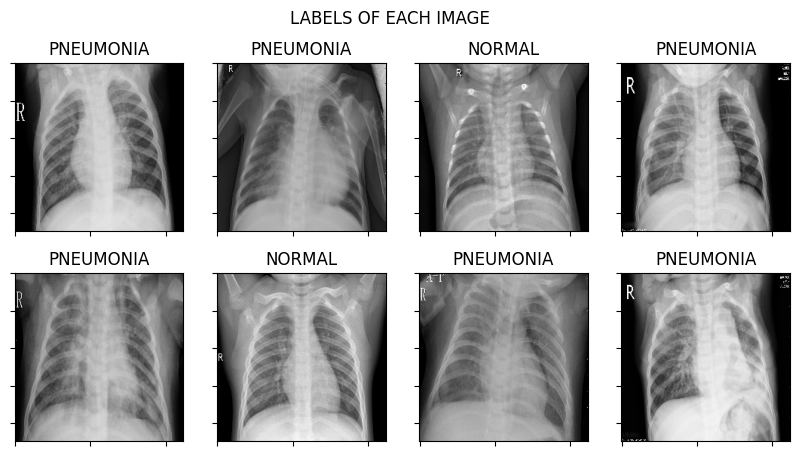

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
plt.suptitle('LABELS OF EACH IMAGE')

for (img, label), ax in zip(random.sample(train_data, 8), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(False)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )

plt.show()

In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [7]:
base_model.trainable = False

In [8]:
num_classes = 2
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [10]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# train_data = [(preprocess_input(input), label) for input, label in train_data]
# val_data = [(preprocess_input(input), label) for input, label in val_data]

X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes)

In [12]:
le.classes_

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

In [13]:
EPOCHS = 10
BATCH_SIZE = 32
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = EPOCHS, batch_size=BATCH_SIZE)

model.save('/kaggle/working/pneumonia.h5')

Epoch 1/10
131/131 [==============================] - 31s 146ms/step - loss: 0.1851 - accuracy: 0.9501 - val_loss: 0.0770 - val_accuracy: 0.9693
Epoch 2/10
131/131 [==============================] - 15s 115ms/step - loss: 0.0738 - accuracy: 0.9732 - val_loss: 0.1245 - val_accuracy: 0.9559
Epoch 3/10
131/131 [==============================] - 15s 117ms/step - loss: 0.0572 - accuracy: 0.9767 - val_loss: 0.1773 - val_accuracy: 0.9435
Epoch 4/10
131/131 [==============================] - 16s 121ms/step - loss: 0.0578 - accuracy: 0.9772 - val_loss: 0.0833 - val_accuracy: 0.9751
Epoch 5/10
131/131 [==============================] - 16s 120ms/step - loss: 0.0472 - accuracy: 0.9837 - val_loss: 0.0695 - val_accuracy: 0.9741
Epoch 6/10
131/131 [==============================] - 15s 118ms/step - loss: 0.0362 - accuracy: 0.9863 - val_loss: 0.0547 - val_accuracy: 0.9799
Epoch 7/10
131/131 [==============================] - 15s 117ms/step - loss: 0.0306 - accuracy: 0.9892 - val_loss: 0.0713 - val_ac

In [14]:
from keras.utils import plot_model

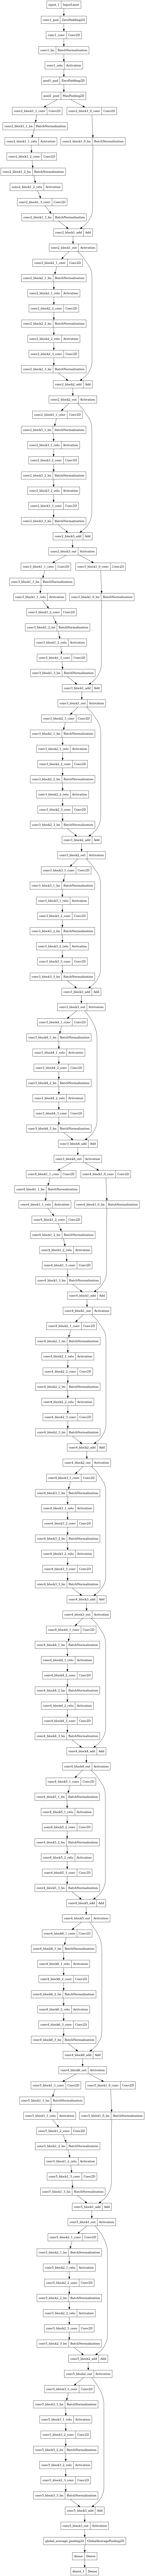

In [15]:
plot_model(model)